# EMPLOYEE PERFORMANCE 

In [1]:
pip install psycopg2

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np   # Defining the libraries to be used
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas.io.sql as sqlio
import psycopg2 as ps

In [3]:
conn = ps.connect(dbname="Capstone",  #Connection to SQL server 
                  user="postgres",
                  password="1234",
                  port="5432")

In [4]:
#SQL Query for EMPLOYEES PERFORMANCE Analysis
sql="""                               
with performance as
(
with representative_list as
(
select e.employee_id, CONCAT(first_name,' ', last_name) as representative, count(distinct customer_id) as customer_amount
from orders as o
left join employees as e
on o.employee_id = e.employee_id
group by 1
having e.employee_id not in (2,5)
)
select representative, customer_amount, '1999-01-01'::date-hire_date as working_days
from representative_list as r
left join employees as e
on r.employee_id = e.employee_id
)
select *, round(100*(customer_amount::decimal/working_days),1) as performance_point
from performance
order by 4 desc"""

In [5]:
df=sqlio.read_sql_query(sql,conn)
df.head(7)

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6400\1681692907.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df=sqlio.read_sql_query(sql,conn)


,representative,customer_amount,working_days,performance_point
0,Margaret Peacock,75,2069,3.6
1,Laura Callahan,56,1763,3.2
2,Nancy Davolio,65,2436,2.7
3,Janet Leverling,63,2466,2.6
4,Robert King,45,1825,2.5
5,Michael Suyama,43,1902,2.3
6,Anne Dodsworth,29,1508,1.9


In [6]:
def level(x):        #Levels of employees are defined based on performance point
    if 1 <= x < 2:
        return "Silver"
    elif 2 <= x < 3:
        return "Bronze"
    elif 3 <= x < 4:
        return "Golden"
df["level"] = df["performance_point"].apply(level) 
df

,representative,customer_amount,working_days,performance_point,level
0,Margaret Peacock,75,2069,3.6,Golden
1,Laura Callahan,56,1763,3.2,Golden
2,Nancy Davolio,65,2436,2.7,Bronze
3,Janet Leverling,63,2466,2.6,Bronze
4,Robert King,45,1825,2.5,Bronze
5,Michael Suyama,43,1902,2.3,Bronze
6,Anne Dodsworth,29,1508,1.9,Silver


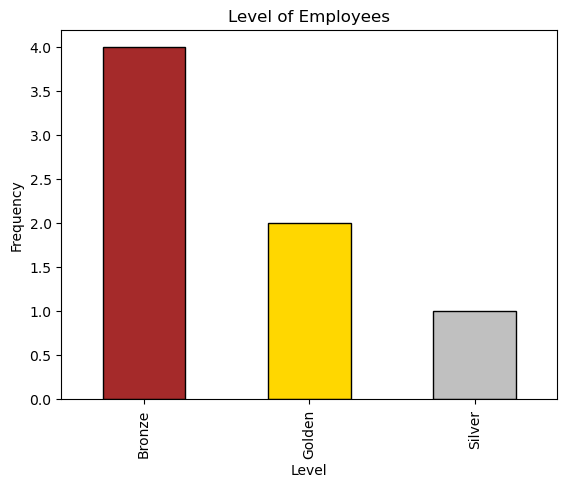

In [7]:
#Distrubition of employees levels
df["level"].value_counts().plot(kind="bar", color=["brown", "gold", "silver"], edgecolor="black")
plt.title("Level of Employees")
plt.xlabel("Level")
plt.ylabel("Frequency")
plt.show()

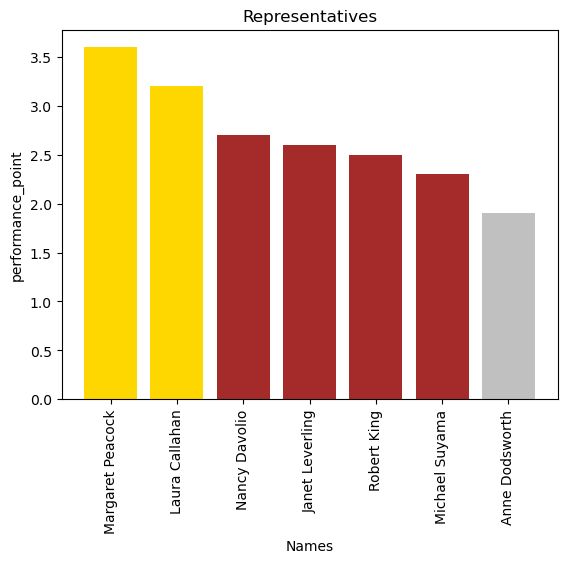

In [8]:
#Checking all employees on graph
colors = []
for x in df["performance_point"]:
    if 1 <= x < 2:
        colors.append("silver")
    elif 2 <= x < 3:
        colors.append("brown")
    else:
        colors.append("gold")
plt.bar(df["representative"], df["performance_point"], color=colors) 
plt.title("Representatives")
plt.xlabel("Names")
plt.ylabel("performance_point")
plt.xticks(rotation=90)
plt.show()

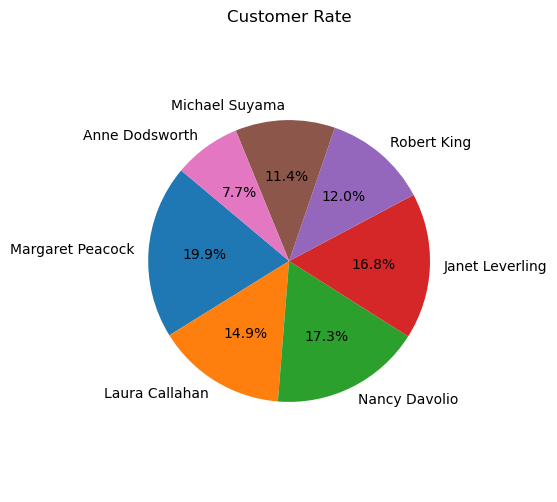

In [9]:
#Distrubition of having customer
plt.figure(figsize=(4,6))
plt.pie(df["customer_amount"], labels=df["representative"], autopct="%1.1f%%", startangle=140)
plt.title("Customer Rate")
plt.axis("equal")
plt.show()

# RFM ANALYSIS FOR CUSTOMERS

In [10]:
#SQL Query for RFM Analysis
sql = """
select od.order_id, customer_id,
round((od.unit_price*od.quantity)*(1-discount)) as final_cost,
order_date as date
from order_details as od 
left join products as p
on od.product_id=p.product_id
left join orders as o
on od.order_id=o.order_id
"""

In [11]:
rfm=sqlio.read_sql_query(sql,conn)
rfm

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6400\3040842897.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  rfm=sqlio.read_sql_query(sql,conn)


,order_id,customer_id,final_cost,date
0,10248,VINET,168.0,1996-07-04
1,10248,VINET,98.0,1996-07-04
2,10248,VINET,174.0,1996-07-04
3,10249,TOMSP,167.0,1996-07-05
4,10249,TOMSP,1696.0,1996-07-05
...,...,...,...,...
2150,11077,RATTC,65.0,1998-05-06
2151,11077,RATTC,17.0,1998-05-06
2152,11077,RATTC,30.0,1998-05-06
2153,11077,RATTC,31.0,1998-05-06


In [15]:
rfm["date"] = pd.to_datetime(rfm["date"])

In [17]:
rfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   order_id     2155 non-null   int64         
 1   customer_id  2155 non-null   object        
 2   final_cost   2155 non-null   float64       
 3   date         2155 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 67.5+ KB


In [19]:
import datetime as dt
snapshot_date = max(rfm.date) + dt.timedelta(days=1)

rfm_data = rfm.groupby(['customer_id']).agg({
    'date': lambda x: (snapshot_date - x.max()).days, # recency 
    'order_id': 'count', # frequency
    'final_cost': 'sum' # monetary
})

In [21]:
rfm_data.rename(columns={'date': 'Recency',
                    'order_id': 'Frequency',
                    'final_cost': 'Monetary'}, inplace=True)

In [22]:
rfm_data

,Recency,Frequency,Monetary
customer_id,,,
ALFKI,28,12,4273.0
ANATR,64,10,1403.0
ANTON,99,17,7023.0
AROUT,27,30,13391.0
BERGS,64,52,24926.0
...,...,...,...
WARTH,22,37,15650.0
WELLI,59,19,6069.0
WHITC,6,40,27362.0


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6400\1264427443.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rfm_data['Recency'])
C:\Users\LENOVO\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


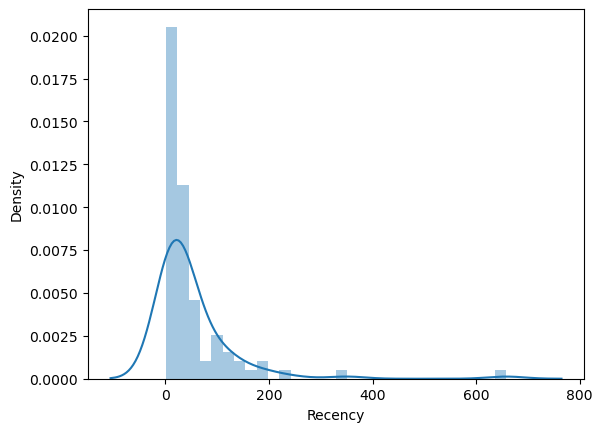

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6400\1264427443.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rfm_data['Frequency'])
C:\Users\LENOVO\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


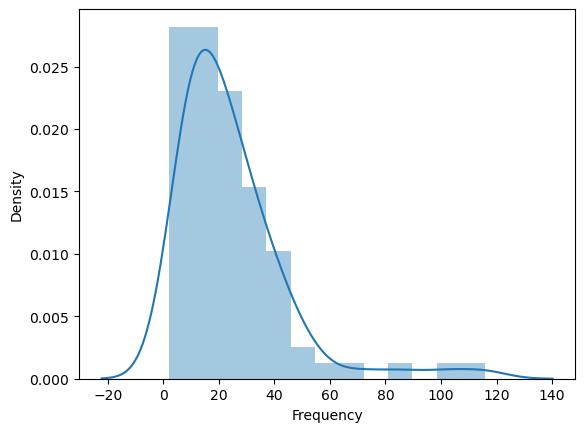

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6400\1264427443.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rfm_data['Monetary'])
C:\Users\LENOVO\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


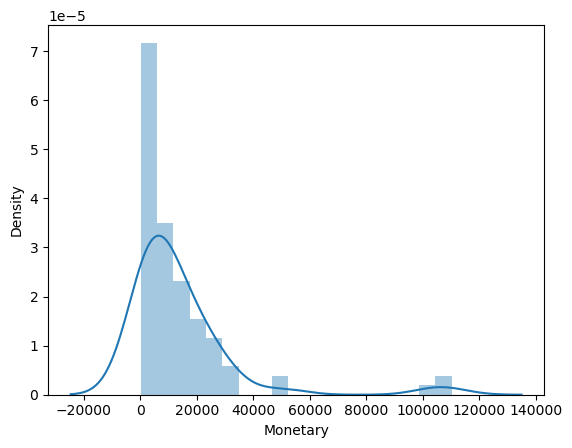

In [26]:
# Recency distrubition 
sns.distplot(rfm_data['Recency'])
plt.show()

# Frequency distrubition
sns.distplot(rfm_data['Frequency'])
plt.show()

# Monetary distrubition
sns.distplot(rfm_data['Monetary'])
plt.show()

In [29]:
#Score & Segment 
rfm_data['R_Score'] = pd.qcut(rfm_data['Recency'], 5, labels=[5, 4, 3, 2, 1])
rfm_data['F_Score'] = pd.qcut(rfm_data['Frequency'], 5, labels=[1, 2, 3, 4, 5])
rfm_data['M_Score'] = pd.qcut(rfm_data['Monetary'], 5, labels=[1, 2, 3, 4, 5])

rfm_data['RFM_Segment'] = rfm_data.apply(lambda x: str(x['R_Score']) + str(x['F_Score']) + str(x['M_Score']), axis=1) 
rfm_data['RFM_Score'] = rfm_data[['R_Score', 'F_Score', 'M_Score']].sum(axis=1) #toplar

In [30]:
rfm_data

,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Segment,RFM_Score
customer_id,,,,,,,,
ALFKI,28,12,4273.0,3,2,2,3.02.02.0,7
ANATR,64,10,1403.0,2,1,1,2.01.01.0,4
ANTON,99,17,7023.0,1,3,3,1.03.03.0,7
AROUT,27,30,13391.0,3,4,4,3.04.04.0,11
BERGS,64,52,24926.0,2,5,5,2.05.05.0,12
...,...,...,...,...,...,...,...,...
WARTH,22,37,15650.0,3,5,4,3.05.04.0,12
WELLI,59,19,6069.0,2,3,3,2.03.03.0,8
WHITC,6,40,27362.0,5,5,5,5.05.05.0,15


In [37]:
# Mapping for segments
segt_map = {
    r'[1-2][1-2]': 'Hibernating',            # Hibernating
    r'[1-2][3-4]': 'At Risk',                # At Risk
    r'[1-2]5': 'Can’t Lose',                 # Can’t Lose
    r'3[1-2]': 'About To Sleep',             # About To Sleep
    r'33': 'Need Attention',                 # Need Attention
    r'[3-4][4-5]': 'Loyal Customers',        # Loyal Customers
    r'41': 'Promising',                      # Promising
    r'51': 'New Customers',                  # New Customers
    r'[4-5][2-3]': 'Potential Loyalists',              # Potential Loyalists
    r'5[4-5]': 'Champions'                   # Champions
}
rfm_data['Segment'] = rfm_data['R_Score'].astype(str) + rfm_data['F_Score'].astype(str)
rfm_data['Segment'] = rfm_data['Segment'].replace(segt_map, regex=True)

In [38]:
rfm_data

,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Segment,RFM_Score,Segment
customer_id,,,,,,,,,
ALFKI,28,12,4273.0,3,2,2,3.02.02.0,7,About To Sleep
ANATR,64,10,1403.0,2,1,1,2.01.01.0,4,Hibernating
ANTON,99,17,7023.0,1,3,3,1.03.03.0,7,At Risk
AROUT,27,30,13391.0,3,4,4,3.04.04.0,11,Loyal Customers
BERGS,64,52,24926.0,2,5,5,2.05.05.0,12,Can’t Lose
...,...,...,...,...,...,...,...,...,...
WARTH,22,37,15650.0,3,5,4,3.05.04.0,12,Loyal Customers
WELLI,59,19,6069.0,2,3,3,2.03.03.0,8,At Risk
WHITC,6,40,27362.0,5,5,5,5.05.05.0,15,Champions


In [39]:
rfm_data['Segment'].value_counts()

Segment
Hibernating            22
Loyal Customers        16
At Risk                13
Champions              12
Potential Loyalists    11
About To Sleep          6
Need Attention          3
New Customers           3
Promising               2
Can’t Lose              1
Name: count, dtype: int64

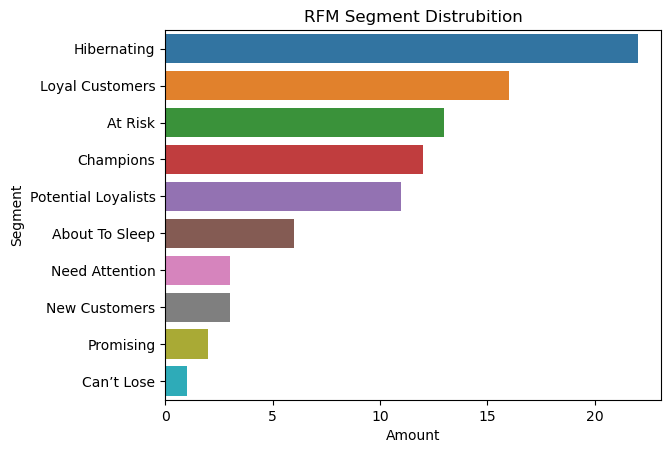

In [40]:
# Segments on graph
sns.countplot(y='Segment', data=rfm_data, order = rfm_data['Segment'].value_counts().index)
plt.title('RFM Segment Distrubition')
plt.xlabel('Amount')
plt.ylabel('Segment')
plt.show()